Установка заисимостей:

In [1]:
# !nvidia-smi
import torch
torch.cuda.is_available()
import torch.nn as nn
# import torch.fx
# import PIL
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

# from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")


In [2]:
from PIL import Image
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            # transforms.RandomResizedCrop(299),
            # transforms.ToTensor().RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [3]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [4]:
TRAIN_DIR = Path(r'C:\Users\asus rog\Downloads\train\simpsons_dataset')
TEST_DIR = Path(r'C:\Users\asus rog\Downloads\testset\testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
val_dataset = SimpsonsDataset(val_files, mode='val')
# uncomment if you have problem with pillow
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions
# import PIL
# from PIL.Image import core as Image
# from PIL import ImageDraw
# from PIL import ImageChops
from torchvision import transforms

In [5]:
len(test_files)

991

Вывод предворительных данных:

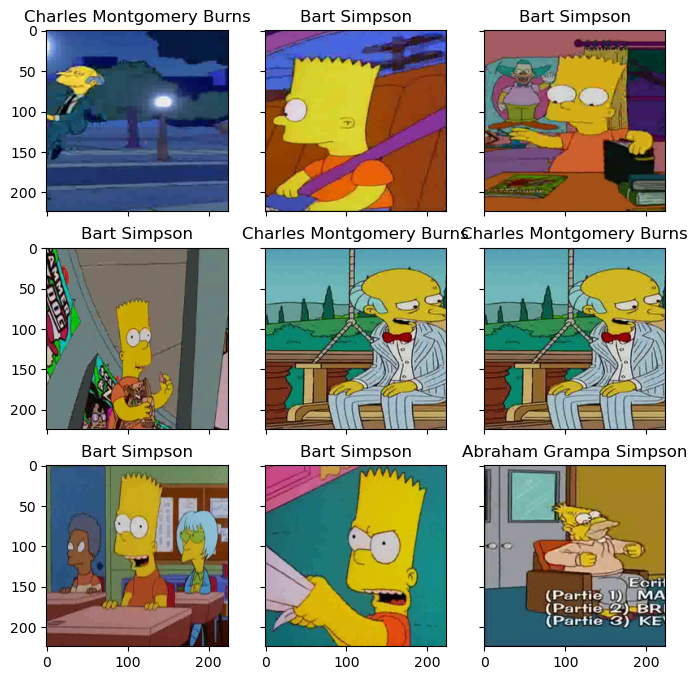

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Пишем функции для тренировки нейросетки:

In [7]:
def fit_epoch(model, train_loader, criterion, optimizer):
    exp_lr_r = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
    
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()

    

  
    for inputs, labels in train_loader:
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
#         exp_lr_r.step()
        inputs = inputs.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [8]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [9]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [10]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to("cpu")
            model.eval()
            outputs = model(inputs).to("cpu")
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Подключаем ResNet 50, блокируем все слои и заменяем полседний слой на подходящий для нашей задачи

In [11]:
from torchvision import datasets, models, transforms
model_extractor = models.resnet50(pretrained=True)
print(model_extractor)

C:\Users\asus rog\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asus rog\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# for param in model_extractor.parameters():
#     print(param.requires_grad)
# print(model_extractor.parameters)
for param in model_extractor.parameters():
    param.requires_grad = False
# for param in model_extractor.layer3.parameters():
#     param.requires_grad = True
# for param in model_extractor.layer4[10:].parameters():
#     param.requires_grad = True
# for param in model_extractor.avgpool.parameters():
#     param.requires_grad = True

In [13]:
nn = 2048
model_extractor.fc = torch.nn.Linear(in_features=2048, out_features=42)
model_extractor.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Прописываем датасет и оптимизатор, который мы используем

In [14]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')


optimizer_ft = torch.optim.AdamW(model_extractor.parameters(), lr=1e-4)

train_dataset = SimpsonsDataset(train_files, mode='train')


Тренируем и выводим график лосса

In [15]:
model_extractor.cuda()
history = train(train_dataset, val_dataset, model=model_extractor, epochs=15, batch_size=56)


epoch:   0%|                                                                                    | 0/15 [00:00<?, ?it/s]

loss 0.8797516120004839


epoch:   7%|█████                                                                      | 1/15 [04:03<56:47, 243.38s/it]


Epoch 001 train_loss: 0.8798     val_loss 0.8776 train_acc 0.7816 val_acc 0.8109
loss 0.41076454014882624


epoch:  13%|██████████                                                                 | 2/15 [08:02<52:09, 240.74s/it]


Epoch 002 train_loss: 0.4108     val_loss 0.4748 train_acc 0.8934 val_acc 0.8804
loss 0.2724757687332782


epoch:  20%|███████████████                                                            | 3/15 [11:58<47:45, 238.81s/it]


Epoch 003 train_loss: 0.2725     val_loss 0.3952 train_acc 0.9243 val_acc 0.8945
loss 0.21434592544990738


epoch:  27%|████████████████████                                                       | 4/15 [15:54<43:32, 237.52s/it]


Epoch 004 train_loss: 0.2143     val_loss 0.2869 train_acc 0.9399 val_acc 0.9230
loss 0.18281991453381571


epoch:  33%|█████████████████████████                                                  | 5/15 [19:49<39:25, 236.51s/it]


Epoch 005 train_loss: 0.1828     val_loss 0.3744 train_acc 0.9490 val_acc 0.9144
loss 0.13001274139514116


epoch:  40%|██████████████████████████████                                             | 6/15 [23:44<35:24, 236.03s/it]


Epoch 006 train_loss: 0.1300     val_loss 0.3203 train_acc 0.9645 val_acc 0.9253
loss 0.11648065415312168


epoch:  47%|███████████████████████████████████                                        | 7/15 [27:39<31:26, 235.79s/it]


Epoch 007 train_loss: 0.1165     val_loss 0.3224 train_acc 0.9665 val_acc 0.9219
loss 0.10226343098060421


epoch:  53%|████████████████████████████████████████                                   | 8/15 [31:36<27:32, 236.08s/it]


Epoch 008 train_loss: 0.1023     val_loss 0.3446 train_acc 0.9718 val_acc 0.9207
loss 0.08843951715040517


epoch:  60%|█████████████████████████████████████████████                              | 9/15 [35:30<23:33, 235.61s/it]


Epoch 009 train_loss: 0.0884     val_loss 0.2887 train_acc 0.9743 val_acc 0.9339
loss 0.06581750920066896


epoch:  67%|█████████████████████████████████████████████████▎                        | 10/15 [39:25<19:37, 235.42s/it]


Epoch 010 train_loss: 0.0658     val_loss 0.3179 train_acc 0.9815 val_acc 0.9270
loss 0.09369112051036502


epoch:  73%|██████████████████████████████████████████████████████▎                   | 11/15 [43:20<15:40, 235.09s/it]


Epoch 011 train_loss: 0.0937     val_loss 0.4889 train_acc 0.9732 val_acc 0.9064
loss 0.10673173841026602


epoch:  80%|███████████████████████████████████████████████████████████▏              | 12/15 [47:14<11:44, 234.79s/it]


Epoch 012 train_loss: 0.1067     val_loss 0.2559 train_acc 0.9697 val_acc 0.9398
loss 0.05292692444692955


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 13/15 [51:07<07:48, 234.48s/it]


Epoch 013 train_loss: 0.0529     val_loss 0.2178 train_acc 0.9854 val_acc 0.9515
loss 0.028093545598232614


epoch:  93%|█████████████████████████████████████████████████████████████████████     | 14/15 [55:05<03:55, 235.49s/it]


Epoch 014 train_loss: 0.0281     val_loss 0.3007 train_acc 0.9917 val_acc 0.9335
loss 0.07348283308790893


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [59:06<00:00, 236.41s/it]


Epoch 015 train_loss: 0.0735     val_loss 0.2549 train_acc 0.9794 val_acc 0.9467


In [16]:
loss, acc, val_loss, val_acc = zip(*history)

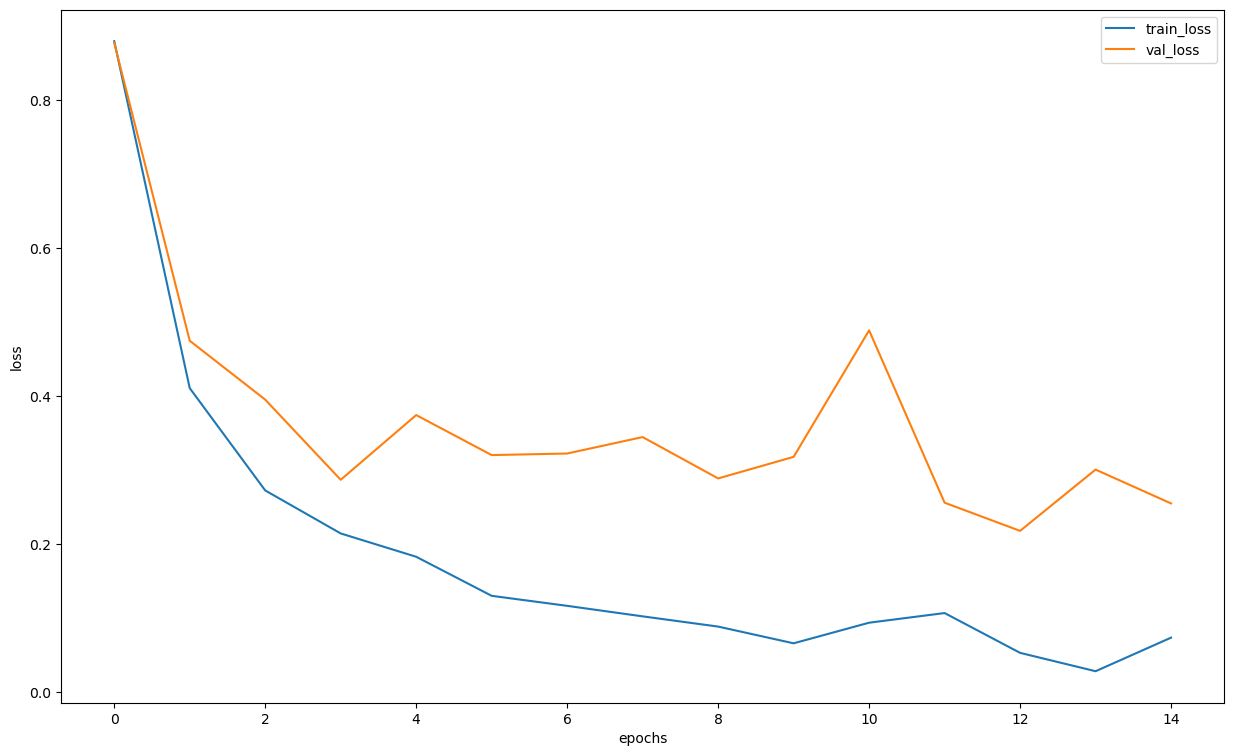

In [17]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best') 
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to("cpu")
        model.eval()
        logit = model(inputs).to("cpu")
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [19]:
model_extractor.to("cpu")
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))
model_extractor.to("cuda")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs
            model.eval()
            outputs = model(inputs)
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
model_extractor.to("cpu")
# imgs.to("cuda")
probs_ims = predict(model_extractor, imgs)

In [22]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [23]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [24]:
from sklearn.metrics import f1_score

print(actual_labels)
print(preds_class)


f1_score(actual_labels, y_pred, average = None)


[4, 4, 3, 2, 6, 4, 4, 4, 6, 6, 4, 6, 6, 0, 4, 4, 4, 0, 2, 2]
['bart_simpson', 'bart_simpson', 'nelson_muntz', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'bart_simpson', 'bart_simpson', 'bart_simpson', 'charles_montgomery_burns', 'charles_montgomery_burns', 'bart_simpson', 'charles_montgomery_burns', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'bart_simpson', 'bart_simpson', 'bart_simpson', 'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon']


array([1., 1., 0., 1., 1., 0.])

Проверяем работу на тестовой выборке

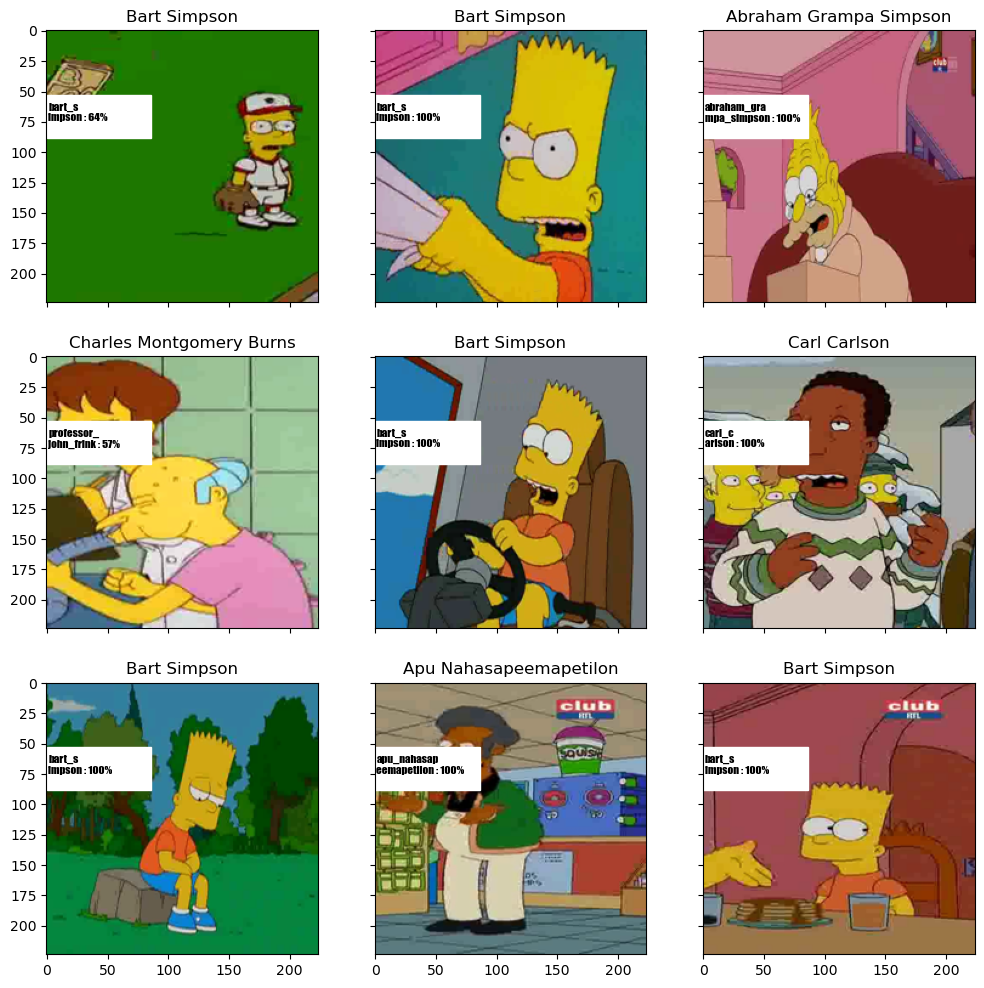

In [25]:
model_extractor.to("cpu")

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Готовим csv для Kaggle

In [26]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [27]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,waylon_smithers
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [28]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)
model_extractor.to("cpu")
random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
# probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]


In [29]:
my_submit.to_csv('resnet.csv', index=False)